In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

In [ ]:
import keras
from keras import layers, models, optimizers
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.utils import resample
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shutil
%matplotlib inline

In [ ]:
train_data = pd.read_csv('../input/fashion.csv')

In [ ]:
sns.countplot(x=train_data['Category'],data=train_data)
plt.title('Count Across Category Types')

From this we observe that the class types are imbalanced and we should adjust this before training the CNN.

In [ ]:
# Downsample category 18,20,25 & 26
# Separate majority and minority classes
train_data_18 = train_data[train_data.Category==18]
train_data_20 = train_data[train_data.Category==20]
train_data_25 = train_data[train_data.Category==25]
train_data_26 = train_data[train_data.Category==26]
train_data_oth = train_data[(train_data.Category!=18) & (train_data.Category!=20) & (train_data.Category!=25) & (train_data.Category!=26)]

In [ ]:
# Downsample majority class
train_data_18_downsampled = resample(train_data_18, 
                                 replace=False,    # sample without replacement
                                 n_samples=15000,     # to match minority class
                                 random_state=123) # reproducible results
train_data_20_downsampled = resample(train_data_20, 
                                 replace=False,    # sample without replacement
                                 n_samples=15000,     # to match minority class
                                 random_state=123) # reproducible results
train_data_25_downsampled = resample(train_data_25, 
                                 replace=False,    # sample without replacement
                                 n_samples=15000,     # to match minority class
                                 random_state=123) # reproducible results
train_data_26_downsampled = resample(train_data_26, 
                                 replace=False,    # sample without replacement
                                 n_samples=15000,     # to match minority class
                                 random_state=123) # reproducible results

# Combine minority class with downsampled majority class
train_data = pd.concat([train_data_18_downsampled, train_data_oth])
train_data = pd.concat([train_data, train_data_20_downsampled])
train_data = pd.concat([train_data, train_data_25_downsampled])
train_data = pd.concat([train_data, train_data_26_downsampled])

# Display new class counts
train_data.Category.value_counts()

In [ ]:
sns.countplot(x=train_data['Category'],data=train_data)
plt.title('Count Across Category Types')

Now that we have downsampled categories with the most images, it's time to prepare the images for CNN.

# Organise images into directories

In [ ]:
cwd = os.getcwd()
print ('Current directory: {}'.format(cwd))

In [ ]:
os.listdir('/kaggle/working/Train/Fashion/test_indi/22/22')

In [ ]:
new_folder_paths = ['Train',
                    os.path.join('Train','Fashion')]
for folder_path in new_folder_paths:
    if (os.path.isdir(folder_path) is False):
        os.mkdir(folder_path)

In [ ]:
folder_path_dict = {i:'Fashion' for i in range(17, 31, 1)}
for category in range(17,31,1):
        
    category_img_paths = train_data[train_data['Category']==category]['image_path'].values.tolist()
    folder_path = os.path.join('Train', folder_path_dict[category], str(category))

    if (os.path.isdir(folder_path) is False):
        os.mkdir(folder_path)

    for img_path in category_img_paths:
        img_name = img_path.split('/')[1]
        corrected_img_path = "../input/fashion_image_resized/fashion_image_resized/train/"
        
        # Copy images into their appropriate category folders
        try:
            shutil.copy(os.path.join('../input/fashion_image_resized/fashion_image_resized/train/', img_name+'.jpg'), os.path.join(folder_path))
#             print('{} moved successfully'.format(img_name))
        except:
            print('{} not found'.format(img_name))
            continue

## Split the Fashion Train set into train & test set

In [ ]:
# Directories for our training & test splits
base_dir = os.path.join(os.getcwd(), 'Train', 'Fashion')
train_dir = os.path.join(base_dir, 'train')
os.mkdir(train_dir)
test_dir = os.path.join(base_dir, 'test')
os.mkdir(test_dir)

# Directory with our training categories
n_labels = 31
for category_id in range(17,n_labels,1):
    train_category_dir = os.path.join(train_dir, str(category_id))
    if (os.path.isdir(train_category_dir) is False):
        os.mkdir(train_category_dir)

# Directory with our test categories
for category_id in range(17,n_labels,1):
    test_category_dir = os.path.join(test_dir, str(category_id))
    if (os.path.isdir(test_category_dir) is False):
        os.mkdir(test_category_dir)

In [ ]:
# Directory for individual subcategory
# Organise data into proper structure
test_indi_dir = os.path.join(base_dir, 'test_indi')
os.mkdir(test_indi_dir)

# Create directories within test_indi
for category_id in range(17,n_labels,1):
    test_indi_category_dir = os.path.join(test_indi_dir, str(category_id))
    if (os.path.isdir(test_indi_category_dir) is False):
        os.mkdir(test_indi_category_dir)
    for category_id in range(17,n_labels,1):
        test_indi_category_dir_int = os.path.join(test_indi_category_dir, str(category_id))
        if (os.path.isdir(test_indi_category_dir_int) is False):
            os.mkdir(test_indi_category_dir_int)

In [ ]:
# Move image files into the train directories
train_ratio = 0.7; test_ratio = 0.3

for category in range(17,31,1):
    category_size = len(os.listdir(os.path.join(base_dir, str(category))))
    train_size = int(train_ratio * category_size)
    test_size = int(test_ratio * category_size)
    
    # Move data from category_dir to create test set for category
    category_dir = os.path.join(base_dir, str(category))
    test_category_dir = os.path.join(test_dir, str(category))
    fnames = os.listdir(category_dir)[train_size:train_size+test_size]
    for fname in fnames:
        src = os.path.join(category_dir, fname)
        dst = os.path.join(test_category_dir, fname)
        shutil.move(src, dst)
        
    # Move data from category_dir to create train set for category
    category_dir = os.path.join(base_dir, str(category))
    train_category_dir = os.path.join(train_dir, str(category))
    fnames = os.listdir(category_dir)[0:train_size]
    for fname in fnames:
        src = os.path.join(category_dir, fname)
        dst = os.path.join(train_category_dir, fname)
        shutil.move(src, dst)

In [ ]:
# Copy images from test set for each category into test_indi categories
for category in range(17,31,1):
    test_category_dir = os.path.join(test_dir, str(category))
    test_indi_category_dir = os.path.join(test_indi_dir, str(category),str(category))
    fnames = os.listdir(test_category_dir)
    for fname in fnames:
        src = os.path.join(test_category_dir, fname)
        dst = os.path.join(test_indi_category_dir, fname)
        shutil.copy(src, dst)

# CNN for Train Set

In [ ]:
# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Prep images for CNN
train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=32,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='categorical')

# Modify this to pass this category by category
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=32,
        class_mode='categorical')

In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', 
                        input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(14, activation='softmax'))

In [ ]:
model.summary()

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.adam(),
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=20)

In [ ]:
model.save('cnn_baseline_fashion.h5')

# Test model on test set

In [31]:
test_loss, test_acc = model.evaluate_generator(test_generator, steps=50, verbose=1)
print('test acc:', test_acc)

50/50 [==============================] - 6s 127ms/step
test acc: 0.22125


> ## Obtain individual sub-category accuracy

In [33]:
test_gen_indi = []
for i in range(17,31,1): # Modify this part if using other datasets
    test_gen_indi.append(test_datagen.flow_from_directory(
        os.path.join(test_indi_dir, str(i)),
        target_size=(150,150),
        batch_size=32,
        class_mode='categorical'))

Found 829 images belonging to 14 classes.
Found 4500 images belonging to 14 classes.
Found 4047 images belonging to 14 classes.
Found 4500 images belonging to 14 classes.
Found 3144 images belonging to 14 classes.
Found 4567 images belonging to 14 classes.
Found 501 images belonging to 14 classes.
Found 1275 images belonging to 14 classes.
Found 4500 images belonging to 14 classes.
Found 4500 images belonging to 14 classes.
Found 4859 images belonging to 14 classes.
Found 1947 images belonging to 14 classes.
Found 1001 images belonging to 14 classes.
Found 432 images belonging to 14 classes.


In [34]:
test_acc_subcat = []
for i, j in enumerate(range(17,31,1)):
    test_loss, test_acc = model.evaluate_generator(test_gen_indi[i], steps=50)
    print('test acc {}:'.format(j), test_acc)
    test_acc_subcat.append(test_acc)

test acc 17: 0.0
test acc 18: 0.08125
test acc 19: 0.295
test acc 20: 0.175625
test acc 21: 0.024375
test acc 22: 0.3875
test acc 23: 0.2131461393855983
test acc 24: 0.0
test acc 25: 0.71875
test acc 26: 0.035625
test acc 27: 0.319375
test acc 28: 0.03375
test acc 29: 0.0
test acc 30: 0.0


In [35]:
test_acc = pd.DataFrame(test_acc_subcat)
subcat = range(17,31)
test_acc['sub_cat'] = subcat 
test_acc.columns = ['Accuracy', 'Sub_cat']

Text(0.5, 1.0, 'Accuracy Across Category Types')

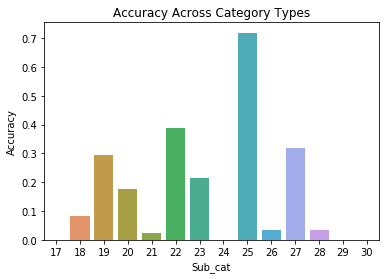

In [36]:
sns.barplot(x=test_acc['Sub_cat'], y=test_acc['Accuracy'],data=test_acc)
plt.title('Accuracy Across Category Types')